In [1]:
import pickle as pkl
import pandas as pd
import numpy as np
from pathlib import Path

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from src import util_analysis 
from scipy import stats 
from copy import deepcopy
import re
from importlib import reload
import matplotlib 
from pprint import pprint

In [ ]:
matplotlib.rcParams.update({'font.size': 10})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

fig_out_dir = Path("final_figures/figure_6")
fig_out_dir.mkdir(exist_ok=True, parents=True)

In [4]:
### Import pre-formated data 

results_dir = Path('final_results_dir')

# diotic SWC 
# diotic_results = pd.read_pickle(results_dir / "df_for_stats_and_summary_2024_SWC_diotic_conditions_humans_N-195_models_v10_w_control_archs_and_50Hz.pdpkl")
diotic_results = pd.read_pickle(results_dir / "experiment_1_df.pdpkl")
diotic_results['experiment'] = 'Diotic'

# Popham SWC
popham_results = pd.read_pickle(results_dir / "df_for_stats_2024_SWC_popham_conditions_humans_N-90_models_v10_w_control_archs.pdpkl")
popham_results.loc[popham_results.group.str.contains("Human"), 'model'] = popham_results.loc[popham_results.group.str.contains("Human"), 'group']
popham_results['snr'] = 0 # add snr column to match diotic_results
popham_conds_to_keep = ['Harmonic_target_Harmonic_distractor',
                        'Harmonic_target_No Distractor_distractor',
                        'Inharmonic_target_Inharmonic_distractor',
                        'Inharmonic_target_No Distractor_distractor',
                        'Whispered_target_No Distractor_distractor',
                        'Whispered_target_Whispered_distractor']

popham_results = popham_results[popham_results['background_condition'].isin(popham_conds_to_keep)].reset_index(drop=True)
popham_results['experiment'] = 'Harmonicity'

# threshold results 
threshold_results = pd.read_pickle(results_dir / "df_for_stats_and_summary_2024_thresholds_humans_N-33_models_v10_w_control_archs.pdpkl")
threshold_results['background_condition'] = threshold_results['azim_delta'].astype('str') + ' azim delta ' + threshold_results['elev_delta'].astype('str') + ' elev delta' 
threshold_results['experiment'] = 'Threshold'
threshold_results.rename(columns={'accuracy_sem': 'acc_sem', 'confusions_sem': 'conf_sem'}, inplace=True)

# Spotlight results 
spotlight_results = pd.read_pickle(results_dir / "df_for_stats_and_summary_2024_spotlight_humans_N-28_models_v10_w_control_archs.pdpkl")
spotlight_results['snr'] = 0 
spotlight_results['background_condition'] = spotlight_results['target_azim'].astype('str') + ' target azim ' + spotlight_results['azim_delta'].astype('str') + ' azim delta'
spotlight_results['experiment'] = 'Spotlight'
spotlight_results.rename(columns={'accuracy_sem': 'acc_sem', 'confusions_sem': 'conf_sem'}, inplace=True)


In [5]:
combined_results = pd.concat([diotic_results, popham_results, threshold_results, spotlight_results], axis=0)
## update model names for comparison 

combined_results.loc[combined_results['model'].str.contains("early"), 'model'] = 'Early-only'
combined_results.loc[combined_results['model'].str.contains("late"), 'model'] = 'Late-only'
combined_results.loc[combined_results['model'].str.contains("control"), 'model'] = 'Baseline CNN'

combined_results['model'] = combined_results['model'].apply(util_analysis.get_model_name)

combined_results = combined_results[combined_results['model'] != "Computed-gain model"].reset_index(drop=True)
combined_results = combined_results[combined_results.model!='50Hz cutoff'].reset_index(drop=True)


In [6]:
combined_results.model.value_counts()

model
Feature-gain alt v8     100
Baseline CNN            100
Feature-gain alt v10    100
Feature-gain alt v12    100
Feature-gain alt v2     100
Feature-gain alt v4     100
Feature-gain alt v6     100
Feature-gain alt v7     100
Feature-gain alt v1     100
Feature-gain alt v9     100
Feature-gain main       100
Early-only              100
Late-only               100
Human (N=195)            56
Human (N=33)             30
Humans (N=28)             8
Humans (N = 90)           6
Name: count, dtype: int64

In [8]:
combined_results['snr_condition_str'] = combined_results['snr'].astype(str) + ' dB ' + combined_results['background_condition']
human_results = combined_results[combined_results.group.str.contains('Human')]
human_results = human_results.sort_values(['snr', 'background_condition'])

model_list = [model for model in combined_results.model.unique() if 'Human' not in model]


model_sim_records = []

for ix, model in enumerate(model_list):

    model_results = combined_results[combined_results.model == model]
    model_results = model_results.sort_values(['snr', 'background_condition'])

    ## Add stats 
    r, p = stats.pearsonr(human_results.accuracy,  model_results.accuracy)
    # spearman_brown_r = r / np.sqrt(main_model_rho_acc)
    acc_r = r ** 2 
    # add to dict 
    acc_rmse = np.sqrt(np.mean((human_results.accuracy.values - model_results.accuracy.values)**2))

    # conf errors
    r, p = stats.pearsonr(human_results.confusions, model_results.confusions)
    conf_r = r ** 2
    conf_rmse = np.sqrt(np.mean((human_results.confusions.values - model_results.confusions.values)**2))

    record = {'model': model, 'acc_r': acc_r, 'acc_rmse': acc_rmse, 'conf_r': conf_r, 'conf_rmse': conf_rmse}
    model_sim_records.append(record)


In [9]:
model_sim_df = pd.DataFrame.from_records(model_sim_records)

In [10]:
# sign test
# from statsmodels.stats.descriptivestats import sign_test

def sign_test(x, mu0):
    n = len(x)
    n_pos = np.sum(x > mu0)
    n_neg = np.sum(x < mu0)
    effect_m = (n_pos - n_neg) / 2 
    p = stats.binomtest(min(n_pos, n_neg), n, p=0.5).pvalue
    return effect_m, p

# run sign test per alternate model 
fba_model_r_acc_dist = model_sim_df.loc[model_sim_df.model.str.contains("main|gain"), "acc_r"].values
fba_model_r_conf_dist = model_sim_df.loc[model_sim_df.model.str.contains("main|gain"), "conf_r"].values

models_to_test = ["Early-only", "Late-only", "Baseline CNN"]

for model in models_to_test:
    y_acc = model_sim_df.loc[model_sim_df.model == model, "acc_r"].values
    stats_result = sign_test(fba_model_r_acc_dist, mu0=y_acc)
    print(f"Feature-gain v {model}, Pearson's r^2 accuracy sign test stat={stats_result[0]} p={stats_result[1]:.5f}")
    y_conf = model_sim_df.loc[model_sim_df.model == model, "conf_r"].values
    stats_result = sign_test(fba_model_r_conf_dist, mu0=y_conf)
    print(f"Feature-gain v {model}, Pearson's r^2 confusions sign test stat={stats_result[0]} p={stats_result[1]:.5f}")
    print("")   

fba_model_r_acc_dist = model_sim_df.loc[model_sim_df.model.str.contains("main|gain"), "acc_rmse"].values
fba_model_r_conf_dist = model_sim_df.loc[model_sim_df.model.str.contains("main|gain"), "conf_rmse"].values

for model in models_to_test:
    y_acc = model_sim_df.loc[model_sim_df.model == model, "acc_rmse"].values
    stats_result = sign_test(fba_model_r_acc_dist, mu0=y_acc)
    print(f"Feature-gain v {model}, RMSE accuracy sign test stat={stats_result[0]} p={stats_result[1]:.5f}")
    y_conf = model_sim_df.loc[model_sim_df.model == model, "conf_rmse"].values
    stats_result = sign_test(fba_model_r_conf_dist, mu0=y_conf)
    print(f"Feature-gain v {model}, RMSE confusions sign test stat={stats_result[0]} p={stats_result[1]:.5f}")
    print("")   


Feature-gain v Early-only, Pearson's r^2 accuracy sign test stat=5.0 p=0.00195
Feature-gain v Early-only, Pearson's r^2 confusions sign test stat=-5.0 p=0.00195

Feature-gain v Late-only, Pearson's r^2 accuracy sign test stat=5.0 p=0.00195
Feature-gain v Late-only, Pearson's r^2 confusions sign test stat=5.0 p=0.00195

Feature-gain v Baseline CNN, Pearson's r^2 accuracy sign test stat=5.0 p=0.00195
Feature-gain v Baseline CNN, Pearson's r^2 confusions sign test stat=2.0 p=0.34375

Feature-gain v Early-only, RMSE accuracy sign test stat=-5.0 p=0.00195
Feature-gain v Early-only, RMSE confusions sign test stat=5.0 p=0.00195

Feature-gain v Late-only, RMSE accuracy sign test stat=-5.0 p=0.00195
Feature-gain v Late-only, RMSE confusions sign test stat=-5.0 p=0.00195

Feature-gain v Baseline CNN, RMSE accuracy sign test stat=-5.0 p=0.00195
Feature-gain v Baseline CNN, RMSE confusions sign test stat=4.0 p=0.02148



In [11]:
### Set up color palette 

# add colors for diotic experimental conditions 
hue_order = ['clean', '1-talker',  '2-talker',  '4-talker', 'babble'] # 'noise',  'music', 'natural scene']
palette={}
palette['clean'] = 'k'

# set speech color gradient 
speech_palette = sns.color_palette("RdPu_r")
speech_order = hue_order[1:][::-1]

for ix, group in enumerate(speech_order):
    palette[group] = speech_palette[ix]

# add colors for noise conditions 
noise_order = ['noise',  'music', 'natural scene']
noise_palette = sns.color_palette("YlOrBr_r", n_colors=6)
noise_order = noise_order[::-1]

for ix, group in enumerate(noise_order):
    palette[group] = noise_palette[ix]

# add same and different sex color palette 
hue_order = ['Different', 'Same']
sex_palette = dict(zip(hue_order, sns.color_palette(palette='colorblind', n_colors=10, as_cmap=False)))
palette['Same'] = sex_palette['Same']
palette['Different'] = 'tab:cyan'
palette['English'] = 'tab:pink'
palette['Mandarin'] = 'seagreen'

# add popham conditions 
for cond in popham_conds_to_keep: 
    if 'No Distractor' in cond:
        palette[cond] = 'k'
    else:
        palette[cond] = 'b'

# add threshold conditions
threshold_conditions = threshold_results.background_condition.unique()
for cond in threshold_conditions:
    if '0 azim delta' in cond:
        # is elevation delta condition 
        palette[cond] = 'tab:blue'
    if 'delta 0 elev delta' in cond:
        palette[cond] = 'tab:orange'
# will make colors for confusions, where popham distractor reports are red 

# add colors for spotlight conditions
spotlight_conditions = spotlight_results.background_condition.unique()
spotlight_cmap = sns.color_palette('tab10', n_colors=8)

for cond in spotlight_conditions:
    if cond.startswith('0 target azim'):
        # is elevation delta condition 
        palette[cond] = spotlight_cmap[7]
    elif cond.startswith('90 target azim'):
        palette[cond] = spotlight_cmap[4]

confusion_palette = {k:v for k, v in palette.items()}
# add popham conditions 
for cond in popham_conds_to_keep: 
    if 'No Distractor' in cond:
        confusion_palette[cond] = 'k'
    else:
        confusion_palette[cond] = 'r'


In [12]:
def pearsons_r(vec_a, vec_b):
    """
    Calculate Pearson's r correlation coefficient between two vectors.
    """
    n = len(vec_a)
    mean_a = np.mean(vec_a)
    mean_b = np.mean(vec_b)
    ss_a = np.sum((vec_a - mean_a) ** 2)
    ss_b = np.sum((vec_b - mean_b) ** 2)
    cov_ab = np.sum((vec_a - mean_a) * (vec_b - mean_b))
    r = cov_ab / np.sqrt(ss_a * ss_b)
    return r

In [13]:
model_list = [model for model in combined_results.model.unique() if ('Human' not in model) and ('50Hz' not in model)]
model_list

['Feature-gain alt v1',
 'Feature-gain alt v10',
 'Feature-gain alt v12',
 'Feature-gain alt v2',
 'Feature-gain alt v4',
 'Feature-gain alt v6',
 'Feature-gain alt v7',
 'Feature-gain alt v8',
 'Feature-gain alt v9',
 'Feature-gain main',
 'Early-only',
 'Late-only',
 'Baseline CNN']

# Plot aggrigate summary 

## Plot bar chart, pooling accuracy and confusions

### Run sign test on pooled similarity scores (pool hits and confusions)

In [14]:
pooled_results = combined_results.melt(id_vars=['snr', 'background_condition', 'model'], value_vars=['accuracy', 'confusions'], var_name='metric', value_name='measure')
pooled_results['condition_str'] = pooled_results['snr'].astype(str) + ' dB ' + pooled_results['background_condition'] + ' ' + pooled_results['metric']

human_results = pooled_results[pooled_results.model.str.contains('Human')]
human_results = human_results.sort_values('condition_str')
model_list = [model for model in pooled_results.model.unique() if 'Human' not in model]

model_sim_records_pooled = []

for ix, model in enumerate(model_list):
    model_results = pooled_results[pooled_results.model == model]
    model_results = model_results.sort_values('condition_str')

    ## Get Pearson's r ^ 2  and RMSE 
    r, p = stats.pearsonr(human_results.measure,  model_results.measure)
    r2 = r ** 2
    rmse = np.sqrt(np.mean((human_results.measure.values - model_results.measure.values)**2))
    # add to dict
    record = {'model': model, 'r2': r2, 'rmse': rmse}
    model_sim_records_pooled.append(record)
model_sim_df_pooled = pd.DataFrame.from_records(model_sim_records_pooled)

In [15]:
## Run sign test
sign_test_dict = []

fba_model_r_dist = model_sim_df_pooled.loc[model_sim_df_pooled.model.str.contains("main|gain"), "r2"].values
fba_model_rmse_dist = model_sim_df_pooled.loc[model_sim_df_pooled.model.str.contains("main|gain"), "rmse"].values

for model in ['Baseline CNN', 'Early-only', 'Late-only']:
    mod_r2 = model_sim_df_pooled.loc[model_sim_df_pooled.model == model, "r2"].values
    r2_stats_result = sign_test(fba_model_r_dist, mu0=mod_r2)
    r2_diff_of_mean = fba_model_r_dist.mean() - mod_r2
    print(f"Feature-gain v {model}, Pearson's r^2 sign test stat={r2_stats_result[0]} p={r2_stats_result[1]:.5f}, diff of mean={r2_diff_of_mean[0]:.5f}")

    mod_rmse = model_sim_df_pooled.loc[model_sim_df_pooled.model == model, "rmse"].values
    rmse_stats_result = sign_test(fba_model_rmse_dist, mu0=mod_rmse)
    rmse_diff_of_mean = fba_model_rmse_dist.mean() - mod_rmse
    print(f"Feature-gain v {model}, RMSE sign test stat={rmse_stats_result[0]} p={rmse_stats_result[1]:.5f}, diff of mean={rmse_diff_of_mean[0]:.5f}")

    print("")
    record = {'model': model,
     'r2_diff': r2_diff_of_mean[0],
     'r2_sign_test_stat': r2_stats_result[0],
     'r2_sign_test_p': r2_stats_result[1],
     'r2_diff_of_mean': r2_diff_of_mean[0],
     'rmse_diff': rmse_diff_of_mean[0],
     'rmse_sign_test_stat': rmse_stats_result[0],
     'rmse_sign_test_p': rmse_stats_result[1],
     'rmse_diff_of_mean': rmse_diff_of_mean[0]
    }
    sign_test_dict.append(record)

sign_test_df = pd.DataFrame.from_records(sign_test_dict)


Feature-gain v Baseline CNN, Pearson's r^2 sign test stat=5.0 p=0.00195, diff of mean=0.09297
Feature-gain v Baseline CNN, RMSE sign test stat=-5.0 p=0.00195, diff of mean=-0.07045

Feature-gain v Early-only, Pearson's r^2 sign test stat=5.0 p=0.00195, diff of mean=0.03552
Feature-gain v Early-only, RMSE sign test stat=-5.0 p=0.00195, diff of mean=-0.03974

Feature-gain v Late-only, Pearson's r^2 sign test stat=5.0 p=0.00195, diff of mean=0.50652
Feature-gain v Late-only, RMSE sign test stat=-5.0 p=0.00195, diff of mean=-0.12504



## Bootstrap confidence intervals for errorbars in plot

This takes a few minutes

In [ ]:
import os
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm.auto import tqdm, trange

np.random.seed(0)
data_for_barplot = combined_results[~combined_results.model.str.contains('alt')].copy()
data_for_barplot.loc[data_for_barplot['group'].str.contains("Human"), 'group'] = 'Human'  


melted_for_errbars = pd.melt(data_for_barplot, id_vars=['snr', 'background_condition', 'group'], value_vars=['accuracy', 'confusions'], var_name='metric', value_name='measure').reset_index(drop=True)
melted_for_errbars['condition_string'] = melted_for_errbars['snr'].astype(str) + ' dB ' + melted_for_errbars['background_condition'] + ' ' + melted_for_errbars['metric']


melted_for_errbars = melted_for_errbars.sort_values(['condition_string'])

model_list = [model for model in melted_for_errbars.group.unique() if 'Human' not in model]

unique_conds = melted_for_errbars.condition_string.unique()
n_conditions = melted_for_errbars.condition_string.nunique()

model_agg_sim_records = []

n_boots = 1000

full_human_measure = melted_for_errbars[melted_for_errbars.group == 'Human'].sort_values(['condition_string'])

def bootstrap_stats(model, full_human_measure_df, melted_df, unique_conds, n_conditions, n_boots=1000):
    model_measure = melted_df[melted_df.group == model].sort_values(['condition_string'])
    full_human_measure = full_human_measure_df.sort_values(['condition_string'])

    r, _ = stats.pearsonr(full_human_measure.measure, model_measure.measure)
    r2_full = r ** 2
    rmse_full = np.sqrt(np.mean((full_human_measure.measure.values - model_measure.measure.values) ** 2))

    r_boots = np.zeros(n_boots)
    rmse_boots = np.zeros(n_boots)

    for ix in range(n_boots):
        conditions_to_sample = np.random.choice(unique_conds, size=n_conditions, replace=True)

        human_sample = np.array([
            full_human_measure.loc[full_human_measure.condition_string == cond, "measure"].item()
            for cond in conditions_to_sample
        ])
        model_sample = np.array([
            model_measure.loc[model_measure.condition_string == cond, "measure"].item()
            for cond in conditions_to_sample
        ])

        r_boot, _ = stats.pearsonr(human_sample, model_sample)
        r_boots[ix] = r_boot ** 2
        rmse_boots[ix] = np.sqrt(np.mean((human_sample - model_sample) ** 2))

    r_ci = np.percentile(r_boots, [2.5, 97.5])
    rmse_ci = np.percentile(rmse_boots, [2.5, 97.5])
    
    return {
        'group': model,
        'r2': r2_full,
        'r2_ci': r_ci,
        'rmse': rmse_full,
        'rmse_ci': rmse_ci
    }

# Parallel execution
model_agg_sim_records = []
# # get number of processors
n_processors = os.cpu_count()

with ProcessPoolExecutor(max_workers=n_processors) as executor:
    futures = {
        executor.submit(
            bootstrap_stats, model, full_human_measure, melted_for_errbars, unique_conds, n_conditions, n_boots
        ): model
        for model in model_list
    }

    for future in tqdm(as_completed(futures), total=len(model_list)):
        model_agg_sim_records.append(future.result())

model_agg_sim_df = pd.DataFrame.from_records(model_agg_sim_records)


  0%|          | 0/4 [00:00<?, ?it/s]

In [19]:
def annot_stat(star, x1, x2, y, h, col='k', ax=None, lw=1.5):
    ax = plt.gca() if ax is None else ax
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=lw, c=col)
    ax.text((x1+x2)*.5, y+h, star, ha='center', va='bottom', color=col)


def draw_stats_bar(ax, x1, x2, y, h, text, th=0.025, lw=1.5, col='k', fontsize=10, text_gap=0.02):
    # Calculate the position of the text
    text_x = (x1 + x2) * 0.5
    text_y = y + th
    
    # Calculate the gap around the text
    gap_half_width = text_gap * len(text) # * (x2 - x1) * 0.5
    
    # Draw the left part of the bar
    ax.plot([x1, x1, text_x - gap_half_width], [y, y + h, y + h], lw=lw, c=col)
    
    # Draw the right part of the bar
    ax.plot([text_x + gap_half_width, x2, x2], [y + h, y + h, y], lw=lw, c=col)
    
    # Draw the text in the middle of the bar
    ax.text(text_x, y-0.002, text, ha='center', va='center', color=col, fontsize=fontsize)
    

def get_star(p_val):
    if p_val < 0.05:
        text = "*"
    if p_val < 0.01:
        text = "**"
    if p_val < 0.001:
        text = "***"
    if p_val < 0.0001:
        text = "****"
    return text

In [ ]:
from copy import deepcopy
to_plot = model_agg_sim_df.copy()

model_order = deepcopy(util_analysis.model_name_order)

to_plot.sort_values('group', key=lambda x: x.map({model: i for i, model in enumerate(model_order)}), inplace=True)

model_order[0] = "Feature-gain\nModel"
to_plot['group'].replace("Feature-gain Model", "Feature-gain\nModel", inplace=True)

x_vals = {model:ix for ix, model in enumerate(model_order)}
to_plot

/tmp/ipykernel_262409/2086919521.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to_plot['group'].replace("Feature-gain Model", "Feature-gain\nModel", inplace=True)


,group,r2,r2_ci,rmse,rmse_ci
3,Feature-gain\nModel,0.964026,"[0.9543869241764615, 0.9728190994338541]",0.074064,"[0.06586728613138346, 0.0820400980770086]"
1,Baseline CNN,0.858287,"[0.8315760797753193, 0.8844234451949322]",0.164488,"[0.1489822004716401, 0.17969000433487273]"
2,Early-only,0.915736,"[0.8995505544848414, 0.9329683378328679]",0.133775,"[0.12117182407337851, 0.14624454400062156]"
0,Late-only,0.444736,"[0.34318708328613734, 0.5404317194118744]",0.219079,"[0.20273902738095168, 0.23703422226228216]"


## Plot figure 6b.

/tmp/ipykernel_262409/757735070.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to_plot['group'].replace("Feature-gain Model", "Feature-gain\nModel", inplace=True)


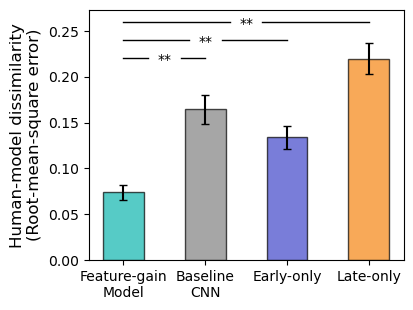

In [21]:
to_plot = model_agg_sim_df.copy()
## add bar plot 
aspect = 3.25
fontsize = 10

fig, ax = plt.subplots(figsize=(aspect*1.25, aspect))


model_order = deepcopy(util_analysis.model_name_order)
model_colors = deepcopy(util_analysis.model_color_dict)

to_plot.sort_values('group', key=lambda x: x.map({model: i for i, model in enumerate(model_order)}), inplace=True)
model_order[0] = "Feature-gain\nModel"
to_plot['group'].replace("Feature-gain Model", "Feature-gain\nModel", inplace=True)

xtick_labels = model_order.copy()
xtick_labels[0] = "Feature-gain\nModel"
xtick_labels[1] = "Baseline\nCNN"
model_colors["Feature-gain\nModel"] = model_colors["Feature-gain Model"]
# sort to_plot based on group, according to model order
x_vals = {model:ix for ix, model in enumerate(model_order)}

bar_width = 0.5

for ix, (_, row) in enumerate(to_plot.iterrows()):
    model = row['group']
    if model not in model_order:
        continue 
    y_err = np.array([row['rmse'] - row['rmse_ci'][0], row['rmse_ci'][1] - row['rmse']])
    y_err = y_err.reshape(2,-1)
    ax.bar(x_vals[model], row['rmse'], yerr=y_err, alpha=0.7, color=model_colors[row['group']], width=bar_width, edgecolor='k', capsize=3)
    # get pval 
    if model != 'Feature-gain\nModel':
        p_val = sign_test_df[sign_test_df.model == model].rmse_sign_test_p.item()
        star = get_star(p_val)
        # annot_stat(star, 0, x_vals[model], 0.95 + ix *.06, 0, ax=ax, lw=1)
        draw_stats_bar(ax, 0, x_vals[model], 0.2 + ix *.02, .00, star, col='k', lw=1, fontsize=fontsize, text_gap=0.1)

# ax.set_ylim(0,1.2)
# ax.set_yticks(np.linspace(0,1,5))
# sns.despine()
ax.set_ylabel("Human-model dissimilarity\n(Root-mean-square error)", fontsize=fontsize+2)
ax.set_xticks(np.arange(len(model_order)))
ax.set_xticklabels(xtick_labels, fontsize=fontsize);


# plt.savefig(fig_out_dir / "figure_6_all_human_model_rmse_sim_bar.pdf", transparent=True, bbox_inches='tight')


## Plot figure 6c. 

This plot will not show error

In [22]:
human_model_sim_df = model_agg_sim_df.copy()
human_model_sim_df

,group,r2,r2_ci,rmse,rmse_ci
0,Late-only,0.444736,"[0.34318708328613734, 0.5404317194118744]",0.219079,"[0.20273902738095168, 0.23703422226228216]"
1,Baseline CNN,0.858287,"[0.8315760797753193, 0.8844234451949322]",0.164488,"[0.1489822004716401, 0.17969000433487273]"
2,Early-only,0.915736,"[0.8995505544848414, 0.9329683378328679]",0.133775,"[0.12117182407337851, 0.14624454400062156]"
3,Feature-gain Model,0.964026,"[0.9543869241764615, 0.9728190994338541]",0.074064,"[0.06586728613138346, 0.0820400980770086]"


In [23]:
palette_for_legend = {}
for cond, hue in palette.items():
    if cond in palette_for_legend:
        continue 
    if 'No Dist' in cond:
        cond = 'clean'
        # palette_for_legend['clean'] = 'k'
    if 'Harmonic_target' in cond or 'Inharmonic_target' in cond or 'Whispered_target' in cond:
        palette_for_legend['Harmonicity target'] = 'b'
        palette_for_legend['Harmonicity distractor'] = 'r'
        continue 
    if cond.startswith('0 azim delta'):
        cond = 'elevation threshold'
    if '0 elev delta' in cond:
        cond = 'azimuth threshold'
        hue = 'orange'
    if cond.startswith('90 target azim'):
        cond = '90$\circ$ azimuth target'
    if cond.startswith('0 target azim'):
        cond = '0$\circ$ elevation target'
    if cond == 'Same':
        cond = 'same sex'
        hue = 'gold'
    if cond == 'Different':
        cond = 'different sex'
    cond = cond if ('0' in cond or '90' in cond) else cond.title() 
    palette_for_legend[cond] = hue

pprint(list(palette_for_legend.keys()))

['Clean',
 'Babble',
 '4-Talker',
 '2-Talker',
 '1-Talker',
 'Natural Scene',
 'Music',
 'Noise',
 'Same Sex',
 'Different Sex',
 'English',
 'Mandarin',
 'Harmonicity target',
 'Harmonicity distractor',
 'Elevation Threshold',
 'Azimuth Threshold',
 '0$\\circ$ elevation target',
 '90$\\circ$ azimuth target']


In [24]:
lgnd_cond_order = ['Clean',
                '1-Talker',
                '2-Talker',
                '4-Talker',
                'Babble',
                'Natural Scene',
                'Music',
                'Noise',
                'Harmonicity target',

                'Same Sex',
                'Different Sex',
                'English',
                'Mandarin',
                'Elevation Threshold',
                'Azimuth Threshold',
                '0$\\circ$ elevation target',
                '90$\\circ$ azimuth target',
                'Harmonicity distractor',
                ]

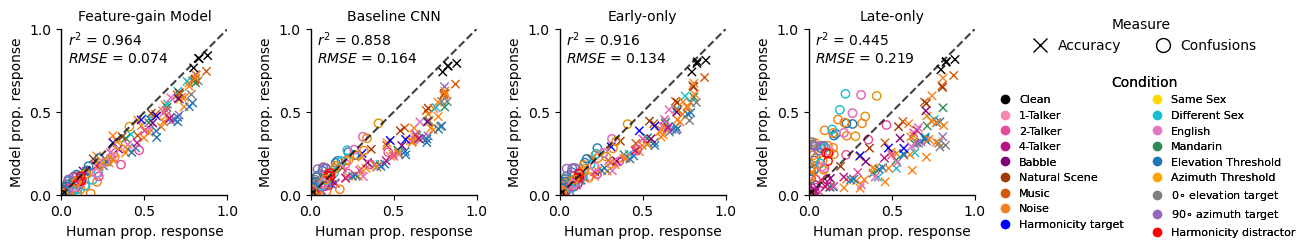

In [ ]:
from matplotlib.lines import Line2D

reload(util_analysis)
combined_results['snr_condition_str'] = combined_results['snr'].astype(str) + ' dB ' + combined_results['background_condition']
human_results = combined_results[combined_results.group.str.contains('Human')]
human_results = human_results.sort_values(['snr', 'background_condition'])

model_order = util_analysis.model_name_order

human_model_sim_df = model_agg_sim_df.copy()

model_acc_r = []
model_conf_r = []
model_acc_rmse = []
model_conf_rmse = []

x = y = np.linspace(0,1,5)
fontsize = 10
aspect = 3

n_rows = 1
n_cols = len(model_order) + 1 

fig, axs = plt.subplots(n_rows, n_cols, 
                        figsize=((aspect * n_cols),
                        aspect*n_rows))

line_width=2

for j in range(len(model_order)):
    axs[j].plot(x,y, ls='dashed', color='k', alpha=0.75)

vert_spacing = 0.1 
conf_max_y = 0.8

conditions = list(palette.keys())


acc_colors = [palette[cond] for cond in human_results.background_condition.values]
conf_colors = [confusion_palette[cond] for cond in human_results.background_condition.values]



for ix, model in enumerate(model_order):
    if model == 'Feature-gain Model':
        fba_to_plot = combined_results[combined_results.group.str.contains('Feature')].groupby(['snr', 'background_condition']).agg({'accuracy': ['mean', 'sem'], 'confusions':['mean', 'sem']}).reset_index()
        fba_to_plot.columns = ['snr', 'background_condition', 'accuracy', 'acc_sem', 'confusions', 'conf_sem']
        fba_to_plot['snr_condition_str'] = fba_to_plot['snr'].astype(str) + ' dB ' + fba_to_plot['background_condition']

        fba_to_plot['group'] = 'Feature-gain Model'
        model_results = fba_to_plot.sort_values(['snr', 'background_condition'])
    else:
        model_results = combined_results[combined_results.model == model]
        model_results = model_results.sort_values(['snr', 'background_condition'])

    axs[ix].scatter(x=human_results.accuracy, y=model_results.accuracy,
                        marker='x', #alpha=0.5,
                        c=acc_colors,
                        linestyle='',
                        #   s=3,
                          )
    axs[ix].scatter(x=human_results.confusions, y=model_results.confusions,
                        marker='o', #alpha=0.5,
                        facecolors='none', edgecolors=conf_colors,
                        linestyle='',
                        #  s=3,
                        )
    
    
    axs[ix].set_title(model, fontsize=fontsize)
    axs[ix].set_xlabel(f"Human prop. response", fontsize=fontsize)
    axs[ix].set_ylabel(f"Model prop. response", fontsize=fontsize)

    r2, rmse  = human_model_sim_df.loc[human_model_sim_df.group == model, ['r2', 'rmse']].values[0]

    ## Add stats 
    axs[ix].annotate(f"$r^2$ = {r2:.3f}", (0.04, 0.9), fontsize=fontsize)
    axs[ix].annotate(f"$RMSE$ = {rmse:.3f}", (0.04, 0.8), fontsize=fontsize)


    # set first row x and y limits to 0 1
ticks = np.linspace(0,1,3).round(1)

for ax in axs.flat[:-1]:
    ax.set_xticks(ticks=ticks) # set new labels
    ax.set_xticklabels(labels=ticks,fontsize=fontsize) 
    ax.set_yticks(ticks=ticks) # set new labels
    ax.set_yticklabels(labels= ticks, fontsize=fontsize)
    ax.set_ylim(0,1)
    ax.set_xlim(0,1)
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(1)
        ax.spines[axis].set_color('k')

## add legend to last pannel for colors and marker shapes 
# Create legend for colors (experiment types)
color_legend_handles = [
    Line2D([0], [0], marker='o', color='w',
           label=cond,
           markerfacecolor=palette_for_legend[cond],
           markersize=8)
    for cond in lgnd_cond_order
]

# Create legend for marker shapes (measurement types)
shape_legend_handles = [
    Line2D([0], [0], marker='x', color='k', linestyle='',
           label='Accuracy', markersize=10),
    Line2D([0], [0], marker='o', color='k', linestyle='',
           markerfacecolor='none', label='Confusions', markersize=10),
]

axs[-1].axis('off')

# Create and add first legend (color legend)
color_legend = fig.legend(handles=color_legend_handles, title="Condition", frameon=False,
                              ncols=2,
                              # reduce space between marker and text 
                              handletextpad=0.25,
                              loc='upper left', fontsize=fontsize-2, title_fontsize=fontsize,
                              bbox_to_anchor=(0.74, 0.65),

                            #   bbox_transform=fig.transFigure
                              )       

# Manually add that legend back to the Axes after the next one overwrites it
axs[-1].add_artist(color_legend)

# Add second legend (shape legend)
fig.legend(handles=shape_legend_handles, title="Measure",  frameon=False,
               ncol=2,
               handletextpad=0.25,
               loc='lower left', fontsize=fontsize, title_fontsize=fontsize,
               bbox_to_anchor=(0.76, 0.65),
            #    bbox_transform=fig.transFigure

)

sns.despine()

plt.subplots_adjust(wspace=0.5)


for ax in axs.flat:
    ax.set(aspect='equal')
# plt.savefig(fig_out_dir / "figure_6_all_human_model_sim_scatter_w_paper_palette.svg", transparent=True, bbox_inches='tight')


## Plot supplementary figure 6

In [26]:
data_for_barplot = combined_results# [~combined_results.model.str.contains('alt')].copy()
data_for_barplot.loc[data_for_barplot['model'].str.contains("Human"), 'group'] = 'Human'  


melted_for_errbars = pd.melt(data_for_barplot, id_vars=['snr', 'background_condition', 'model'], value_vars=['accuracy', 'confusions'], var_name='metric', value_name='measure').reset_index(drop=True)
melted_for_errbars['condition_string'] = melted_for_errbars['snr'].astype(str) + ' dB ' + melted_for_errbars['background_condition'] + ' ' + melted_for_errbars['metric']


melted_for_errbars = melted_for_errbars.sort_values(['condition_string'])

model_list = [model for model in melted_for_errbars.model.unique() if 'Human' not in model]
model_list

['Late-only',
 'Feature-gain alt v10',
 'Early-only',
 'Feature-gain alt v12',
 'Feature-gain alt v2',
 'Feature-gain alt v1',
 'Feature-gain alt v6',
 'Feature-gain alt v7',
 'Feature-gain main',
 'Feature-gain alt v8',
 'Feature-gain alt v4',
 'Feature-gain alt v9',
 'Baseline CNN']

In [27]:
import os
from concurrent.futures import ProcessPoolExecutor, as_completed


np.random.seed(0)
data_for_barplot = combined_results# [~combined_results.model.str.contains('alt')].copy()
data_for_barplot.loc[data_for_barplot['model'].str.contains("Human"), 'model'] = 'Human'  


melted_for_errbars = pd.melt(data_for_barplot, id_vars=['snr', 'background_condition', 'model'], value_vars=['accuracy', 'confusions'], var_name='metric', value_name='measure').reset_index(drop=True)
melted_for_errbars['condition_string'] = melted_for_errbars['snr'].astype(str) + ' dB ' + melted_for_errbars['background_condition'] + ' ' + melted_for_errbars['metric']


melted_for_errbars = melted_for_errbars.sort_values(['condition_string'])

model_list = [model for model in melted_for_errbars.model.unique() if 'Human' not in model]

unique_conds = melted_for_errbars.condition_string.unique()
n_conditions = melted_for_errbars.condition_string.nunique()

all_model_agg_sim_records = []

n_boots = 1000

full_human_measure = melted_for_errbars[melted_for_errbars.model == 'Human'].sort_values(['condition_string'])

def bootstrap_stats(model, full_human_measure_df, melted_df, unique_conds, n_conditions, n_boots=1000):
    model_measure = melted_df[melted_df.model == model].sort_values(['condition_string'])
    full_human_measure = full_human_measure_df.sort_values(['condition_string'])

    r, _ = stats.pearsonr(full_human_measure.measure, model_measure.measure)
    r2_full = r ** 2
    rmse_full = np.sqrt(np.mean((full_human_measure.measure.values - model_measure.measure.values) ** 2))

    r_boots = np.zeros(n_boots)
    rmse_boots = np.zeros(n_boots)

    for ix in range(n_boots):
        conditions_to_sample = np.random.choice(unique_conds, size=n_conditions, replace=True)

        human_sample = np.array([
            full_human_measure.loc[full_human_measure.condition_string == cond, "measure"].item()
            for cond in conditions_to_sample
        ])
        model_sample = np.array([
            model_measure.loc[model_measure.condition_string == cond, "measure"].item()
            for cond in conditions_to_sample
        ])

        r_boot, _ = stats.pearsonr(human_sample, model_sample)
        r_boots[ix] = r_boot ** 2
        rmse_boots[ix] = np.sqrt(np.mean((human_sample - model_sample) ** 2))

    r_ci = np.percentile(r_boots, [2.5, 97.5])
    rmse_ci = np.percentile(rmse_boots, [2.5, 97.5])
    
    return {
        'model': model,
        'r2': r2_full,
        'r2_ci': r_ci,
        'rmse': rmse_full,
        'rmse_ci': rmse_ci
    }

# Parallel execution
all_model_agg_sim_records = []
# get number of processors
n_processors = os.cpu_count()

with ProcessPoolExecutor(max_workers=n_processors) as executor:
    futures = {
        executor.submit(
            bootstrap_stats, model, full_human_measure, melted_for_errbars, unique_conds, n_conditions, n_boots
        ): model
        for model in model_list
    }

    for future in tqdm(as_completed(futures), total=len(model_list)):
        all_model_agg_sim_records.append(future.result())

all_model_agg_sim_df = pd.DataFrame.from_records(all_model_agg_sim_records)


  0%|          | 0/13 [00:00<?, ?it/s]

In [28]:
lgnd_cond_order = ['Clean',
                '1-Talker',
                '2-Talker',
                '4-Talker',
                'Babble',
                'Natural Scene',
                'Music',
                'Noise',
                'Harmonicity target',

                'Same Sex',
                'Different Sex',
                'English',
                'Mandarin',
                'Elevation Threshold',
                'Azimuth Threshold',
                '0$\\circ$ elevation target',
                '90$\\circ$ azimuth target',
                'Harmonicity distractor',
                ]

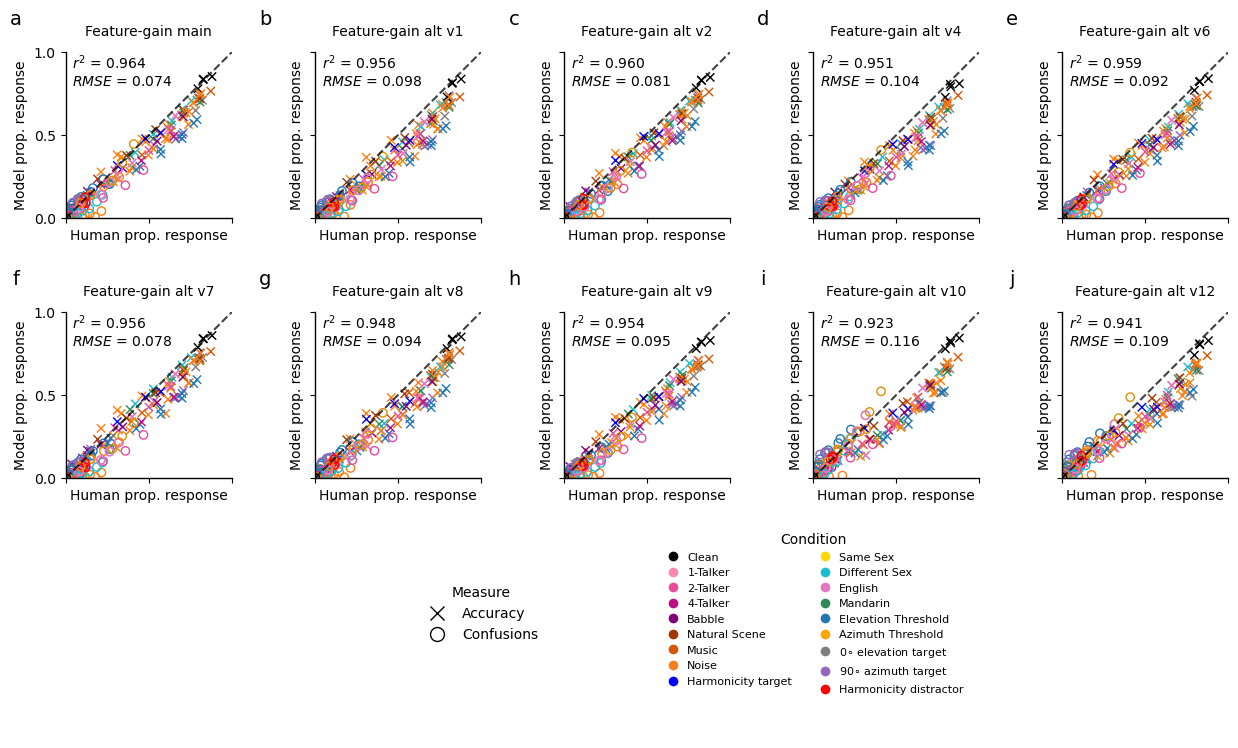

In [29]:
from matplotlib.lines import Line2D

reload(util_analysis)
combined_results['snr_condition_str'] = combined_results['snr'].astype(str) + ' dB ' + combined_results['background_condition']
human_results = combined_results[combined_results.group.str.contains('Human')]
human_results = human_results.sort_values(['snr', 'background_condition'])

all_models = combined_results.model.unique()
all_models = [model for model in all_models if 'Human' not in model and '50Hz' not in model]
model_order = ["Baseline CNN", 'Early-only', 'Late-only',  ]
# nat sort the other archs 
also_sort = [m for m in all_models if m not in model_order and 'computed' not in m and 'rand' not in m and 'main' not in m]
model_order = ['Feature-gain main'] + sorted(also_sort, key=lambda x: int(re.search(r'\d+', x).group())) # +  model_order

all_model_agg_sim_df = all_model_agg_sim_df.copy()

model_acc_r = []
model_conf_r = []
model_acc_rmse = []
model_conf_rmse = []

x = y = np.linspace(0,1,5)
fontsize = 10
aspect = 3


n_models = len(model_order)

# make mosaic subplot where feature gain models occur first, legend is under
pattern = '''abcde
             fghij
             ..k..'''

legend_subplot = 'k'
feature_gain_panels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
model_panels = feature_gain_panels 

n_cols = 5
n_rows = int(np.ceil(n_models / n_cols)) +  1
fig, axs = plt.subplot_mosaic(pattern,
                            #   layout='constrained',
                              width_ratios=[1, 1, 1, 1, 1],
                              height_ratios=[aspect] * n_rows,
                              figsize=(aspect * n_cols, aspect  * n_rows),
                              sharex=True,
                              sharey=True,
                              )


line_width=2
# add dashed line to each subplot 
for ax in model_panels:
    axs[ax].plot(x,y, ls='dashed', color='k', alpha=0.75)

vert_spacing = 0.1 
conf_max_y = 0.8

acc_colors = [palette[cond] for cond in human_results.background_condition.values]
conf_colors = [confusion_palette[cond] for cond in human_results.background_condition.values]

for ix, model in enumerate(model_order):
    ix = model_panels[ix]
    model_results = combined_results[combined_results.model == model]
    model_results = model_results.sort_values(['snr', 'background_condition'])

    axs[ix].scatter(x=human_results.accuracy, y=model_results.accuracy,
                        marker='x', #alpha=0.5,
                        c=acc_colors,
                        linestyle='',
                        #   s=3,
                          )
    axs[ix].scatter(x=human_results.confusions, y=model_results.confusions,
                        marker='o', #alpha=0.5,
                        facecolors='none', edgecolors=conf_colors,
                        linestyle='',
                        #  s=3,
                        )
    
    
    axs[ix].set_title(model, fontsize=fontsize, y=1.05)
    axs[ix].set_xlabel(f"Human prop. response", fontsize=fontsize)
    axs[ix].set_ylabel(f"Model prop. response", fontsize=fontsize)

    r2, rmse  = all_model_agg_sim_df.loc[all_model_agg_sim_df.model == model, ['r2', 'rmse']].values[0]

    ## Add stats 
    axs[ix].annotate(f"$r^2$ = {r2:.3f}", (0.04, 0.9), fontsize=fontsize)
    axs[ix].annotate(f"$RMSE$ = {rmse:.3f}", (0.04, 0.8), fontsize=fontsize)


    # set first row x and y limits to 0 1
ticks = np.linspace(0,1,3).round(1)

for ax in axs.values():
    ax.set_xticks(ticks=ticks) # set new labels
    ax.set_xticklabels(labels=ticks,fontsize=fontsize) 
    ax.set_yticks(ticks=ticks) # set new labels
    ax.set_yticklabels(labels= ticks, fontsize=fontsize)
    ax.set_ylim(0,1)
    ax.set_xlim(0,1)
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(1)
        ax.spines[axis].set_color('k')

## add legend to last pannel for colors and marker shapes 
# Create legend for colors (experiment types)
color_legend_handles = [
    Line2D([0], [0], marker='o', color='w',
           label=cond,
           markerfacecolor=palette_for_legend[cond],
           markersize=8)
    for cond in lgnd_cond_order
]


# Create legend for marker shapes (measurement types)
shape_legend_handles = [
    Line2D([0], [0], marker='x', color='k', linestyle='',
           label='Accuracy', markersize=10),
    Line2D([0], [0], marker='o', color='k', linestyle='',
           markerfacecolor='none', label='Confusions', markersize=10),
]



axs[legend_subplot].axis('off')
# Create and add first legend (color legend)
color_legend = axs[legend_subplot].legend(handles=color_legend_handles, title="Condition", frameon=False,
                              ncol=2, 
                              handletextpad=0.25,
                              loc='center', fontsize=fontsize-2, title_fontsize=fontsize,
                              bbox_to_anchor=(1.5, .75),
                            #   bbox_transform=fig.transFigure
                              )       

# Manually add that legend back to the Axes after the next one overwrites it
axs[legend_subplot].add_artist(color_legend)

# Add second legend (shape legend)
axs[legend_subplot].legend(handles=shape_legend_handles, title="Measure",  frameon=False,
               loc='center', fontsize=fontsize, title_fontsize=fontsize,
               bbox_to_anchor=(-0.5, .75),
)

sns.despine()

# plt.subplots_adjust(wspace=0.5)

# add panel lettering to top left of each pannel
for ix, ax in enumerate(axs.values()):
    if ix < n_models:
        ax.text(-0.3, 1.2, f'{chr(97+ix)}', transform=ax.transAxes, fontsize=fontsize+4, va='center', ha='center')


# adjust space between pannels
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for ax in axs.values():
    ax.set(aspect='equal')
# plt.savefig(fig_out_dir / "figure_6_all_human_model_sim_scatter_all_arch_supp.svg", transparent=True, bbox_inches='tight')
